In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from statsmodels.stats import weightstats 

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

1. `school` — аббревиатура школы, в которой учится ученик

2. `sex` — пол ученика ('F' - женский, 'M' - мужской)

3. `age` — возраст ученика (от 15 до 22)

4. `address` — тип адреса ученика ('U' - городской, 'R' - за городом)

5. `famsize` — размер семьи('LE3' <= 3, 'GT3' >3)

6. `Pstatus` — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

7. `Medu` — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

8. `Fedu` — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

9. `Mjob` — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

10. `Fjob` — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

11. `reason` — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

12. `guardian` — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

13. `traveltime` — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

14. `studytime` — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

15. `failures` — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

16. `schoolsup` — дополнительная образовательная поддержка (yes или no)

17. `famsup` — семейная образовательная поддержка (yes или no)

18. `paid` — дополнительные платные занятия по математике (yes или no)

19. `activities` — дополнительные внеучебные занятия (yes или no)

20. `nursery` — посещал детский сад (yes или no)

21. `higher` — хочет получить высшее образование (yes или no)

22. `internet` — наличие интернета дома (yes или no)

23. `romantic` — в романтических отношениях (yes или no)

24. `famrel` — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

25. `freetime` — свободное время после школы (от 1 - очень мало до 5 - очень мого)

26. `goout` — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

27. `health` — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

28. `absences` — количество пропущенных занятий

29. `score` — баллы по госэкзамену по математике

In [58]:
stud_math = pd.read_csv('stud_math.csv')

In [74]:
df = stud_math.copy()

# переименуем колонки для удобства
df.columns = ('school', 'sex', 'age', 'address', 'famsize',
                     'p_status', 'm_edu', 'f_edu', 'm_job', 'f_job',
                     'reason', 'guardian', 'traveltime', 'studytime',
                     'failures', 'schoolsup', 'famsup', 'paid',
                     'activities', 'nursery', 'studytime, granular',
                     'higher', 'internet', 'romantic', 'famrel',
                     'freetime', 'goout', 'health', 'absences', 'score')


# удалим пропущенные значения в переменной score
delete_df = df[df.score.isna()]
df = df.drop(delete_df.index)


def outliers_check(sample):
    ''' The function takes Pandas.Series
        then calculate outliers 
        and return df with them '''

    Q1 = sample.quantile(0.25)
    Q3 = sample.quantile(0.75)
    IQR = Q3 - Q1
    df = pd.DataFrame(sample)
    df['up_outliers'] = pd.Series(sample > (Q3 + IQR*1.5))
    df['down_outliers'] = pd.Series(sample < (Q1 - IQR*1.5))

    if df.up_outliers.nunique() == 1 and df.down_outliers.nunique() == 1:
        return print('Выбросы не найдены')
    else:
        return df[(df.down_outliers == True) | (df.up_outliers == True)]

### 1. Осмотр данных и проверка на пустые значения

In [75]:
display(df.head(10))
df.info() 

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               389 non-null    object 
 1   sex                  389 non-null    object 
 2   age                  389 non-null    int64  
 3   address              374 non-null    object 
 4   famsize              362 non-null    object 
 5   p_status             344 non-null    object 
 6   m_edu                386 non-null    float64
 7   f_edu                365 non-null    float64
 8   m_job                370 non-null    object 
 9   f_job                353 non-null    object 
 10  reason               372 non-null    object 
 11  guardian             358 non-null    object 
 12  traveltime           361 non-null    float64
 13  studytime            382 non-null    float64
 14  failures             367 non-null    float64
 15  schoolsup            380 non-null    obj

In [76]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,389.0,16.673522,1.265662,15.0,16.0,17.0,18.0,22.0
m_edu,386.0,2.766839,1.094277,0.0,2.0,3.0,4.0,4.0
f_edu,365.0,2.627397,2.241790,0.0,2.0,3.0,3.0,40.0
traveltime,361.0,1.434903,0.692660,1.0,1.0,1.0,2.0,4.0
studytime,382.0,2.036649,0.847239,1.0,1.0,2.0,2.0,4.0
failures,367.0,0.326975,0.729479,0.0,0.0,0.0,0.0,3.0
"studytime, granular",382.0,-6.109948,2.541716,-12.0,-6.0,-6.0,-3.0,-3.0
famrel,362.0,3.930939,0.931554,-1.0,4.0,4.0,5.0,5.0
freetime,380.0,3.223684,0.993364,1.0,3.0,3.0,4.0,5.0
goout,382.0,3.094241,1.116104,1.0,2.0,3.0,4.0,5.0


In [77]:
df.isna().sum()

school                  0
sex                     0
age                     0
address                15
famsize                27
p_status               45
m_edu                   3
f_edu                  24
m_job                  19
f_job                  36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 38
paid                   39
activities             14
nursery                15
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime                9
goout                   7
health                 15
absences               11
score                   0
dtype: int64

In [78]:
df.score.unique()

array([ 30.,  50.,  75.,  55.,  95.,  45.,  60.,  70.,  80.,  25.,  40.,
        85.,  90.,  65., 100.,  35.,   0.,  20.])

Обнаружена переменная, которой нет в описании studytime, granular.  
Обнаружено 6 пустых значений в переменной score - отвечающей за успеваемость, т.к. это целевая переменная, необходимо удалить эти значения. __Убрано в предобработку.__   
Но для начала приведём названия переменных в более удобный вид. __Убрано в предобработку.__ 

In [79]:
# проверяем удаление
print(f'Количество пустых значений в переменной score = {len(df[df.score.isna()])}')
df.info()

Количество пустых значений в переменной score = 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               389 non-null    object 
 1   sex                  389 non-null    object 
 2   age                  389 non-null    int64  
 3   address              374 non-null    object 
 4   famsize              362 non-null    object 
 5   p_status             344 non-null    object 
 6   m_edu                386 non-null    float64
 7   f_edu                365 non-null    float64
 8   m_job                370 non-null    object 
 9   f_job                353 non-null    object 
 10  reason               372 non-null    object 
 11  guardian             358 non-null    object 
 12  traveltime           361 non-null    float64
 13  studytime            382 non-null    float64
 14  failures             367 non-null    flo

### 2. Анализ данных в столбцах
#### school
В переменной нет пустых значений.

In [80]:
df.school.nunique()

2

In [82]:
df.school.unique()

array(['GP', 'MS'], dtype=object)

In [83]:
df.school.value_counts()

GP    344
MS     45
Name: school, dtype: int64

Итого в наборе данных представлены ученики из двух школ.  
Посмотрим, влияет ли эта переменная на итоговую успеваемость или, другими словами, оценим различается ли качество преподавания в разных школах?  
Для этого сначала оценим распределение частоты оценок в зависимости отшколы и выясним есть ли выбросы.

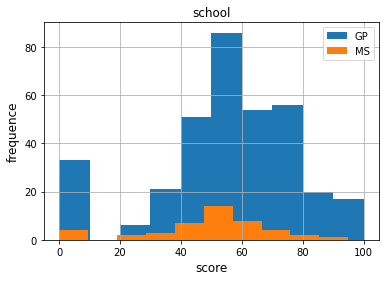

In [84]:
GP = df[df.school == 'GP'].score.copy()
MS = df[df.school == 'MS'].score.copy()
GP.hist(label='GP')
MS.hist(label='MS')
# fig, ax = plt.gcf(), plt.gca()
plt.xlabel('score',fontsize = 12)
plt.ylabel('frequence',fontsize = 12)
plt.title('school')
plt.grid(True)
plt.legend()
plt.show()

Распределение оценок в школах схожее, похоже что нет разницы в качестве обучения.  
Необходимо проверить с помощью теста Стьюдента.

In [17]:
# проверим есть ли выбросы
outliers_check(GP)

Выбросы не найдены


In [18]:
outliers_check(MS)

,score,up_outliers,down_outliers
367,0.0,False,True
383,0.0,False,True
387,0.0,False,True
389,0.0,False,True


Найдены выбросы в распеределении оценок в группе MS.  
Посмотрим, как выглядят на гистограммы распределения с выбросами и без.

25-й перцентиль GP: 40.0, 75-й перцентиль GP: 70.0, GP_IQR: 30.0,  Границы выбросов: [-5.0, 115.0].



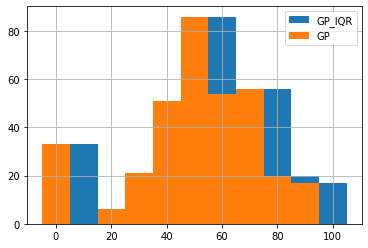

In [19]:
GP_Q1 = GP.quantile(0.25)
GP_Q3 = GP.quantile(0.75)
GP_IQR = GP_Q3 - GP_Q1

print(
'25-й перцентиль GP: {},'.format(GP_Q1),
'75-й перцентиль GP: {},'.format(GP_Q3),
"GP_IQR: {}, ".format(GP_IQR),
"Границы выбросов: [{f}, {l}].\n".format(f=GP_Q1 - 1.5*GP_IQR, l=GP_Q3 + 1.5*GP_IQR))
 
GP.loc[GP.between(
GP_Q1 - 1.5*GP_IQR,
GP_Q3 + 1.5*GP_IQR)].hist(bins = 10, range = (0, 100), label = 'GP_IQR', align = 'right')
GP.hist(label='GP', bins = 10, align = 'left')
plt.legend()


25-й перцентиль MS: 40.0, 75-й перцентиль MS: 65.0, MS_IQR: 25.0,  Границы выбросов: [2.5, 102.5].


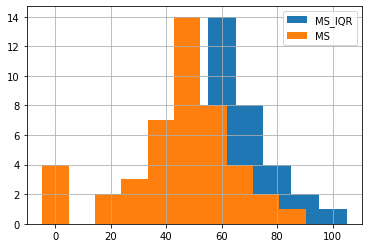

In [85]:
MS_Q1 = MS.quantile(0.25)
MS_Q3 = MS.quantile(0.75)
MS_IQR = MS_Q3 - MS_Q1

print(
'25-й перцентиль MS: {},'.format(MS_Q1),
'75-й перцентиль MS: {},'.format(MS_Q3),
"MS_IQR: {}, ".format(MS_IQR),
"Границы выбросов: [{f}, {l}].".format(f=MS_Q1 - 1.5*MS_IQR, l=MS_Q3 + 1.5*MS_IQR))
 
MS.loc[MS.between(
MS_Q1 - 1.5*MS_IQR,
MS_Q3 + 1.5*MS_IQR)].hist(bins = 10, range = (0, 100), label = 'MS_IQR', align = 'right')
MS.hist(label='MS', bins = 10, align = 'left')
plt.legend()

Заменим выбросы в группе MS на медианое значение. Т.к. все выбросы равны 0, то сделаем это используя только инструменты Pandas.

In [102]:
# заменяем выбросы на медиану
df.loc[((df['school'] == 'MS') & (df['score'] == 0)), ['score']] = MS.quantile(0.5)
# проверяем изменения
df[df.index.isin([367,383,387,389])]

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
367,MS,F,17,R,NaN,T,1.0,1.0,other,services,reputation,mother,3.0,1.0,1.0,no,yes,yes,no,yes,-3.0,yes,yes,yes,5.0,2.0,1.0,1.0,0.0,50.0
383,MS,M,19,R,GT3,T,1.0,1.0,other,services,other,mother,2.0,1.0,1.0,no,no,no,no,NaN,-3.0,yes,no,no,4.0,3.0,2.0,5.0,0.0,50.0
387,MS,F,19,R,GT3,T,2.0,3.0,services,other,course,mother,1.0,3.0,1.0,no,no,no,yes,no,-9.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,50.0
389,MS,F,18,U,GT3,T,1.0,1.0,other,other,course,mother,NaN,2.0,1.0,no,no,no,yes,yes,-6.0,yes,NaN,no,1.0,1.0,1.0,5.0,0.0,50.0


Воспользуемся Т-тестом для оценки значимости различий между оценками полученными в разных школах.
Т.к. выборки достаточно большие и случайные, согласно центральной предельной теореме мы можем считать что их распределение приблизительно нормальное. 

In [107]:
GP = df[df.school == 'GP'].score.copy()
MS = df[df.school == 'MS'].score.copy()
weightstats.ttest_ind(GP,MS) # T test для выборки

(-0.35562179318461723, 0.7223175780510509, 387.0)

p-value = 0.72, нулевая гипотеза подтверждается, между средними выборок нет различий.
Можно предположить, что уровень преподавания в этих школах одинаковый.